In [1]:
from copy import deepcopy
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from functools import partial
from imblearn.under_sampling import RandomUnderSampler
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, 
    confusion_matrix,
    roc_auc_score, roc_curve
)
from sklearn.model_selection import train_test_split

plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
# Globals
FRAC_SAMPLE = 0.2     # should be 1.0 in final version ;)
FRAC_TEST_DATA = 0.1  # ToDo: Find reasonable size.

In [3]:
data = pd.read_parquet('data/2_featured/tripfeatures.parquet')
data.columns = [col.lower().replace('_', ' ') for col in data.columns]
data = data.sample(frac=FRAC_SAMPLE)

In [4]:
data.head()

,is subscriber,gender,tripduration in h,start dow,start month,start hour,customer age,trip distance in km,trip speed kmh,feelslike,humidity,snowdepth,windspeed
21875007,Subscriber,Female,0.072500,5 Friday,08 August,8,33,0.489650,6.753798,87.0,71.5,0.0,16.1
9256567,Subscriber,Male,0.180556,2 Tuesday,09 September,23,27,2.151533,11.916154,88.4,62.2,0.0,6.0
604283,Subscriber,Male,0.116111,4 Thursday,05 May,19,28,1.819296,15.668593,79.4,40.1,0.0,19.7
6867766,Subscriber,Male,0.188889,3 Wednesday,04 April,19,25,0.488077,2.583934,41.8,48.5,0.0,14.3
23387377,Subscriber,Male,0.121944,2 Tuesday,12 December,18,47,1.475350,12.098584,30.0,59.8,0.0,9.4


### Create dummy variables from Categorial ones

Create a function to generate categorical variables for columns with discrete values. Then use undersampling before constructing the features is order to reduce load on memory.

In [5]:
def convert_object_dtypes_to_int(df):
    dtypes = df.dtypes
    object_type_vars = dtypes[dtypes == 'object']

    for var in object_type_vars.index:
        df[var] = df[var].copy().astype('float64')
    
    return df


def generate_categories_with_baseline(
    categorical_variables_with_baseline: dict[str],
    X: pd.DataFrame
    
):
    # shorten
    cvwb = categorical_variables_with_baseline
    # loop over each categorical variable to construct binary ones.
    for var, base_cat in cvwb.items():
        category_df = pd.get_dummies(X[var], prefix=var)
        category_df.columns = [col.lower().replace('_', ': ') for col in category_df]
        X = pd.concat([X,category_df] , axis=1)
        
        # construct baseline full name and drop it.
        baseline_name = f"{var}: {base_cat}"
        X = X.drop(baseline_name, axis=1) # remove base category
        
        # Drop generator variable
        X = X.drop(var, axis=1)
    
    return X
    

# Manually set up baseline categories (todo: think about using the lowest cat name by default)
categorical_variables_with_baseline={
    #'gender': 'male', 
    'start dow': '0 sunday', 
    'start hour': '8', 
    'start month': '05 may',
}

data = data.drop('gender', axis=1)

gen_cats_with_base = partial(
    generate_categories_with_baseline, 
    categorical_variables_with_baseline=categorical_variables_with_baseline
)

In [6]:
# Generate some interactions of valuable variables.
data["customer age        x trip speed kmh"] = data["customer age"].astype(float) * data["trip speed kmh"]
data["trip distance in km x trip speed kmh"] = data["trip distance in km"] * data["trip speed kmh"]
data["feelslike           x trip speed kmh"] = data["feelslike"] * data["trip speed kmh"]

In [7]:
# split into endogenous and exogenous variables.
X = data.loc[:, data.columns != 'is subscriber']
y = data.loc[:, data.columns == 'is subscriber']


# Prepare some dtypes as those are loaded as object type.
y = (y["is subscriber"] == 'Subscriber').astype(np.uint8)

# Generate Training and Test dataset
Xt, Xtt, yt, ytt = train_test_split(X, y, test_size = FRAC_TEST_DATA, random_state = 0)
yt, ytt = yt.astype('int'), ytt.astype('int')

### Under-sampling

In [8]:
print(f"""Counts before under-sampling:
\tN Training Rows: {len(Xt)}
\tN Test Rows: {len(Xtt)}

\tN Training Subscriber: {len(yt[yt==1])}
\tN Training Customer:   {len(yt[yt==0])}
""")
      
rus = RandomUnderSampler(random_state=0, sampling_strategy=1.0)
Xt, yt = rus.fit_resample(Xt, yt)

print(f"""Counts after under-sampling:
\tN Training Rows: {len(Xt)}
\tN Test Rows: {len(Xtt)}

\tN Training Subscriber: {len(yt[yt==1])}
\tN Training Customer:   {len(yt[yt==0])}
""")

Counts before under-sampling:
	N Training Rows: 4243187
	N Test Rows: 471466

	N Training Subscriber: 3800347
	N Training Customer:   442840

Counts after under-sampling:
	N Training Rows: 885680
	N Test Rows: 471466

	N Training Subscriber: 442840
	N Training Customer:   442840



In [9]:
# Transform categories of training and test data to binary analogues.
Xt = gen_cats_with_base(X=Xt)
Xtt = gen_cats_with_base(X=Xtt)

# regression models will not accept object types as input, thus convert.
# Has to be done after generation of categories.
Xt = convert_object_dtypes_to_int(Xt)
Xtt = convert_object_dtypes_to_int(Xtt)

# add constants to exogenous variables.
Xt = sm.add_constant(Xt)
Xtt = sm.add_constant(Xtt)

# drop intermediate dataframe and arrays to save memory
del data
del X
del y

### Implementing the model

In [10]:
# copute logistic regression
logit_mod = sm.Logit(yt, Xt)
logit_res = logit_mod.fit()
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.463675
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          is subscriber   No. Observations:               885680
Model:                          Logit   Df Residuals:                   885628
Method:                           MLE   Df Model:                           51
Date:                Sun, 11 Sep 2022   Pseudo R-squ.:                  0.3311
Time:                        15:11:10   Log-Likelihood:            -4.1067e+05
converged:                       True   LL-Null:                   -6.1391e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    0.2685      0.0

### Report Metrics

In [11]:
yhat_prob = logit_res.predict(Xtt)
yhat = np.round(yhat_prob).astype(int)

print(classification_report(ytt, yhat))

              precision    recall  f1-score   support

           0       0.30      0.80      0.44     49382
           1       0.97      0.78      0.87    422084

    accuracy                           0.79    471466
   macro avg       0.64      0.79      0.65    471466
weighted avg       0.90      0.79      0.82    471466



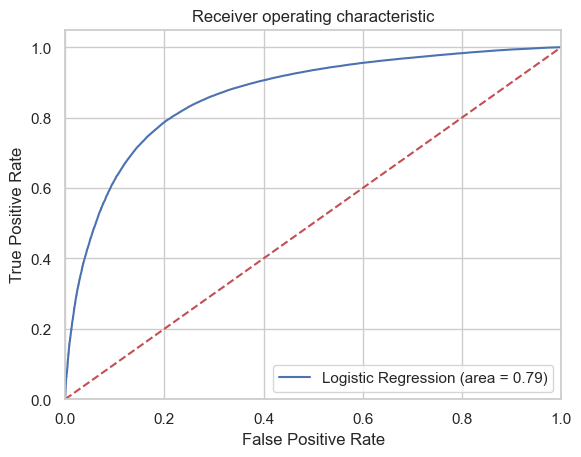

In [12]:
logit_roc_auc = roc_auc_score(ytt, yhat)
fpr, tpr, thresholds = roc_curve(ytt, yhat_prob)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Generalization

Now, try to put all the summarizing elements from above into a single function and run several models.

This is somehow inspired by a medium blog post. However, I've tried to generalize the sequential approach taken in the blog post a bit ([Top 10 Binary Classification Algorithms [a Beginner’s Guide]](https://towardsdatascience.com/top-10-binary-classification-algorithms-a-beginners-guide-feeacbd7a3e2)) 

## Reminder on Precision, Recall and F1-Score

Copied from ([A Look at Precision, Recall, and F1-Score](https://towardsdatascience.com/a-look-at-precision-recall-and-f1-score-36b5fd0dd3ec)) 

**Accuracy**

$$ \frac{\text{number of correct predictions}}{\text{size of dataset}} = \frac{TP + TN}{TP + FP + TN + FN} $$

**Precision**: Share of correctly predicted Subscribers.

$$ \frac{\text{True Positives}}{\text{True Positives + False Positives}}$$

**Recall / Sensitivity**

$$ \frac{\text{True Positives}}{\text{True Positives + True Negatives}}$$

**Specificity**

$$ \frac{\text{True Negatives}}{\text{True Negatives + False Positives}} $$

**F1-Score**: Harmonic mean of Precision and Recall

$$ \frac{\text{Precision * Recall}}{\text{Precision + Recall}} $$

In [13]:
import os
import sklearn
import time
import textwrap
import sklearn.metrics as metrics

def get_model_name(model) -> str:
    return str(type(model)).split('.')[-1].replace("'>", "")
                
# Run several models with a loop that always calls the constructed interface above.
models = [
    sklearn.linear_model.LogisticRegression(max_iter=10000),
    sklearn.tree.DecisionTreeClassifier(),
    sklearn.ensemble.BaggingClassifier(
        sklearn.tree.DecisionTreeClassifier(),
        max_samples=0.5,
        max_features=1.0,
        n_estimators=10
    ),
    sklearn.ensemble.AdaBoostClassifier(
        sklearn.tree.DecisionTreeClassifier(
            min_samples_split=10,
            max_depth=4
        ),
        n_estimators=10,
        learning_rate=0.6
    ),
    sklearn.ensemble.RandomForestClassifier(
        n_estimators=30, 
        max_depth=9
    ),
]
    
# Compute different Scores for each estimator
df_scores = pd.DataFrame()
for mod in models:
    # generate minimal output
    start_time = time.time()
    
    # fit model and predict y_hat for test data.
    mod.fit(Xt, yt)
    ytt_hat = mod.predict(Xtt)
    
    # report current model and needed time.
    print(f"Estimated {get_model_name(mod)} in {time.time() - start_time:3.2f} seconds")
    
    # compute several metrics to compare
    df_mod = pd.DataFrame.from_dict(
        {
            "Accuracy":  np.round([metrics.accuracy_score(ytt, ytt_hat)], 3),
            "Precision": np.round([metrics.precision_score(ytt, ytt_hat)], 3),
            "Recall":    np.round([metrics.recall_score(ytt, ytt_hat)], 3),
            "F1-Score":  np.round([metrics.f1_score(ytt, ytt_hat)], 3),
            "ROC AUC":   np.round([metrics.roc_auc_score(ytt, ytt_hat)], 3),
        }, orient='columns'
    )
    df_mod.index = [get_model_name(mod)]
    df_scores = pd.concat([df_scores, df_mod], axis=0)
    
# cleanup
del Xt
del yt
del Xtt
del ytt

df_scores.sort_values('F1-Score', ascending=False).head()

Estimated LogisticRegression in 264.54 seconds
Estimated KNeighborsClassifier in 276.14 seconds
Estimated DecisionTreeClassifier in 15.59 seconds
Estimated BaggingClassifier in 59.83 seconds
Estimated AdaBoostClassifier in 33.79 seconds
Estimated RandomForestClassifier in 22.39 seconds


,Accuracy,Precision,Recall,F1-Score,ROC AUC
AdaBoostClassifier,0.878,0.980,0.883,0.929,0.863
RandomForestClassifier,0.858,0.977,0.861,0.916,0.845
BaggingClassifier,0.852,0.981,0.850,0.911,0.857
DecisionTreeClassifier,0.811,0.975,0.810,0.885,0.816
KNeighborsClassifier,0.803,0.975,0.801,0.879,0.812


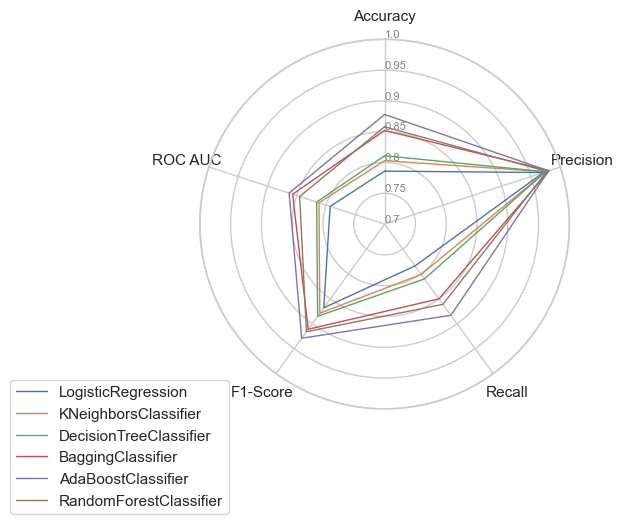

In [14]:
# number of variable
categories=df_scores.columns
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * math.pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(math.pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)
 
# compute appropriate labels and sizing.
ymin = np.floor(10 * df_scores.min().min()) / 10.0
ymax = np.ceil(10 * df_scores.max().max()) / 10.0
yticks = np.round(np.arange(ymin, ymax, 0.05), 2)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks(yticks, [str(val) for val in yticks], color="grey", size=8)
plt.ylim(ymin, ymax)

# Plot each individual = each line of the data
for idx, row in df_scores.iterrows():
    values = row.values.flatten().tolist()
    values += values[:1] # start = end for line.
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=idx)

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.show()